In [1]:
import glob
import numpy as np
from pathlib import Path
from math import floor
import timeit
import os
import random
import matplotlib.pyplot as plt

pdb_path = "/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/metrics"
tp_files = list(Path(pdb_path).rglob("*tp.npy"))

tp_files_str = [str(os.path.basename(path)) for path in tp_files]
pfam_ids = [tp_str[5:12] for tp_str in tp_files_str] 
pdb_ids = [tp_str[:4] for tp_str in tp_files_str] 
print(pfam_ids)
print(pdb_ids)
tprs = []
fprs = []
for i, pdb_id in enumerate(pdb_ids):
    pfam_id = pfam_ids[i]
    fp_file = "%s/%s_%s_ER_fp.npy" % (pdb_path, pdb_id, pfam_id)
    tp_file = "%s/%s_%s_MF_tp.npy" % (pdb_path, pdb_id, pfam_id)
    fprs.append(np.load(fp_file))
    tprs.append(np.load(tp_file))


['PF00704', 'PF00186', 'PF00062', 'PF00062', 'PF00293', 'PF05063', 'PF00244', 'PF03459', 'PF00081', 'PF00056', 'PF01462']
['1xrv', '1zdr', '1oud', '4yop', '5fsl', '6ttw', '7nm9', '1gut', '3sdp', '6itl', '2ft3']


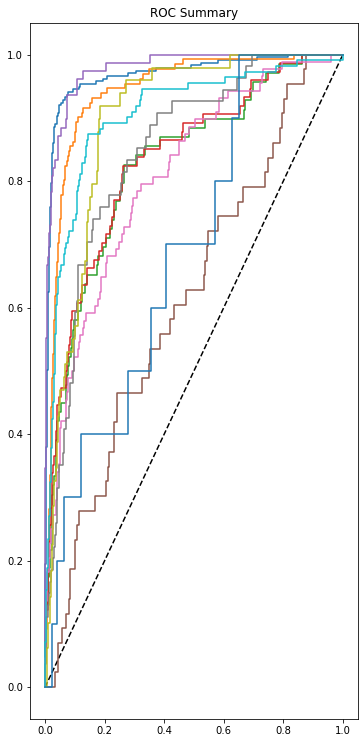

In [2]:
plt.figure(figsize=(27.0,12.8))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC Summary')
plt.plot([0,1],[0,1],'k--')

for i, tpr in enumerate(tprs):
    fpr = fprs[i]
    try:
        plt.plot(fpr, tpr)
    except:
        pass
plt.show()